this notebook tries to reproduce the CNN part of Fig. 7 in the paper, based on <https://github.com/leelabcnbc/tang_jcompneuro_revision/blob/master/results_ipynb/plots/main/demo_fitted_neurons.ipynb>


# data preprocessing.

raw data are saved under `results/datasets/`

* `tang_stimulus.hdf5` pattern stimuli.
* `MonkeyA.hdf5` mean responses for Monkey A.
* `MonkeyE2.hdf5` mean responses for Monkey B.

CNN training needs the data split into training, validation, and testing data, and the script `split_datasets.py` has already been run to generate ready-to-use data for this notebook. The split data are saved in `results/datasets/split_data.hdf5`.

In [1]:
%matplotlib inline
import numpy as np
import h5py
import os.path
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import h5py
import time

In [2]:
from torchvision.utils import make_grid
from torch import FloatTensor

In [3]:
from tang_jcompneuro.io import load_image_dataset, load_neural_dataset, load_split_dataset

In [4]:
_get_all_data_cache = dict()
def get_all_data():
    if 'X' not in _get_all_data_cache:
        _get_all_data_cache['X'] = load_image_dataset('Shape_9500', normalize_cnn_format=True)
    if 'y' not in _get_all_data_cache:
        _get_all_data_cache['y'] = load_neural_dataset('MkA_Shape',return_positive=True)
    X, y = _get_all_data_cache['X'], _get_all_data_cache['y']
    assert X.shape == (9500,1,40,40)
    assert y.shape == (9500,1142)
    return X, y

In [5]:
def show_top_stimuli(neuron_idx_this):
    # load actual neuron response
    actual_response_this_ALL = get_all_data()[1][:, neuron_idx_this]
    assert actual_response_this_ALL.shape == (9500,)
    actual_response_sort_idx_ALL = np.argsort(actual_response_this_ALL)[::-1]
    # show top 20 stimuli, 10 x 2.
    X_top_this_ALL = get_all_data()[0][actual_response_sort_idx_ALL[:20]]

    # use torchvision to get a 10 x 2 grid and show it.
    X_top_this_ALL = make_grid(FloatTensor(X_top_this_ALL)[:20], nrow=10, normalize=False, scale_each=False)
    X_top_this_ALL = np.transpose(X_top_this_ALL.numpy(), (1, 2, 0))
    plt.close('all')
    plt.imshow(X_top_this_ALL)
    plt.show()

In [6]:
# these are the indices of example neurons in Fig. 7.
cnn_training_map = {
    'OT': 578,  # orientation
    'CV': 553,  # curvature
    'CN': 459,  # corner
    'CRS': 1079, # cross
    'Other': 4, # composition
}


In [7]:
# change it for other neurons.
neuron_to_work_on = cnn_training_map['CN']

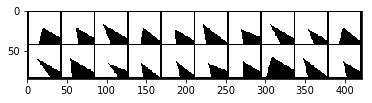

In [8]:
show_top_stimuli(neuron_to_work_on)

In [9]:
from tang_jcompneuro.cnn import CNN

In [10]:
from tang_jcompneuro.model_fitting_cnn import (opt_configs_to_explore, models_to_train,
                                               init_config_to_use_fn, train_one_case)

In [11]:
opt_configs_to_explore.keys()
# you can select one optimization hyperparameter set out of 4.
# in the paper, we choose the one with highest validation performance for final testing.

odict_keys(['1e-3L2_1e-3L2_sgd_mse', '1e-3L2_1e-3L2_adam002_mse', '1e-4L2_1e-3L2_sgd_mse', '1e-4L2_1e-3L2_adam002_mse'])

In [12]:
def imshow_inner(npimg, figsize=(8, 6), save_name=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    img_to_show = np.transpose(npimg.numpy(), (1, 2, 0))
    plt.imshow(img_to_show)
    
    if save_name is not None:
        imsave(save_name, img_to_show)
    
    plt.show()

In [13]:
def train_one_model(neuron_idx, opt_config_to_use = '1e-3L2_1e-3L2_sgd_mse',
                   num_channel=4):
    # change num_channel to 9 for 9 channel CNN, etc.
    # print `models_to_train` for more options.
    arch_config = models_to_train[f'b.{num_channel}']
    
    # load datasets splitted in train/val/test.
    
    datasets_local = load_split_dataset('MkA_Shape', 'all', True, neuron_idx)
    
    # init CNN.
    model = CNN(arch_config, init_config_to_use_fn(), mean_response=datasets_local[1].mean(axis=0),
                seed=0,
                input_size=20,
                )
    
    t1 = time.time()
    # train.
    y_val_cc, y_test_hat, new_cc = train_one_case(model, datasets_local,
                                                  opt_configs_to_explore[opt_config_to_use],
                                                  seed=2, show_every=1000,
                                                  return_val_perf=True,
                                                  max_epoch=20000)
    t2 = time.time()
    print(t2-t1, 'sec')
    print('corr', new_cc)
    
     
    # get params.
    kernels = None
    fc_weights = None
    for param_name, param_val in model.named_parameters():
        if param_name == 'conv.conv0.weight':
            kernels = param_val.data.numpy()
        if param_name == 'fc.fc.weight':
            fc_weights = param_val.data.numpy()

    fc_weights_per_kernel = (fc_weights**2).reshape(num_channel,4,4).sum(axis=(1,2))
    # first is channel.
    assert fc_weights_per_kernel.shape == (num_channel,) and np.all(fc_weights_per_kernel>=0)
    del model
    
    # per kernel, weighted.
    imshow_inner(make_grid(FloatTensor(kernels*fc_weights_per_kernel[:,np.newaxis,np.newaxis,np.newaxis]),
                          normalize=True, scale_each=False))
    
    
    # show tuning curve for test.
    x_axis_range = np.arange(1900)
    y_test = datasets_local[3]
    assert y_test.shape == y_test_hat.shape == (1900,1)
    y_all_test_this_sortidx = np.argsort(y_test.ravel())[::-1]
    
    plt.close('all')
    fig, ax_this = plt.subplots(1,1,squeeze=1)
    
    ax_this.plot(x_axis_range, y_test.ravel()[y_all_test_this_sortidx], label='raw')
    ax_this.plot(x_axis_range, y_test_hat.ravel()[y_all_test_this_sortidx], label=f'CNN b.{num_channel}')
    ax_this.legend(loc='upper right')
    ax_this.set_xlim(0, 300)
    ax_this.set_ylabel('response')
    
    plt.show()

========starting phase 1/1==========
========starting epoch 1000==========
val metric
 {'neg_corr': -0.82932395, 'corr': 0.82932395, 'mse': 0.0048907576}
test metric
 {'neg_corr': -0.8033275, 'corr': 0.8033275, 'mse': 0.0050070109}
========done epoch 1000==========
========starting epoch 2000==========
val metric
 {'neg_corr': -0.83566302, 'corr': 0.83566302, 'mse': 0.004607569}
test metric
 {'neg_corr': -0.80348653, 'corr': 0.80348653, 'mse': 0.004908815}
========done epoch 2000==========
========starting epoch 3000==========
val metric
 {'neg_corr': -0.82486397, 'corr': 0.82486397, 'mse': 0.0054574301}
test metric
 {'neg_corr': -0.78552806, 'corr': 0.78552806, 'mse': 0.0055761309}
========done epoch 3000==========
early stopping after epoch 3000
========end phase 1/1==========
15.68557357788086 sec
corr 0.803487


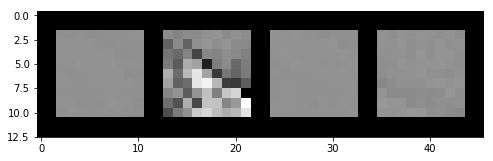

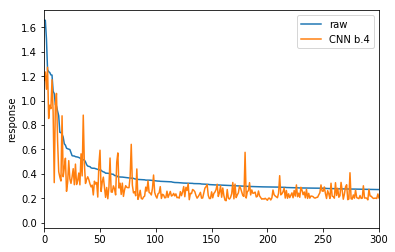

In [14]:
train_one_model(neuron_to_work_on)